In [1]:
"""
基础_模型迁移_CBIR_augmentation
by jsxyhelu
"""
#!apt-get -qq install -y graphviz && pip install -q pydot

import numpy as np
import cv2
import os
import math
import h5py as h5py 

import pydot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image

from keras.utils.data_utils import get_file
from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

/home/ian/installed/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#训练集和验证集比率
RATIO = 0.2
#根据分类总数确定one-hot总类
NUM_DENSE = 5
#训练总数
epochs = 30
#默认图片大小:512*512
ishape=48
#one hot TODO给改掉
def tran_y(y): 
    y_ohe = np.zeros(NUM_DENSE) 
    y_ohe[y] = 1 
    return y_ohe

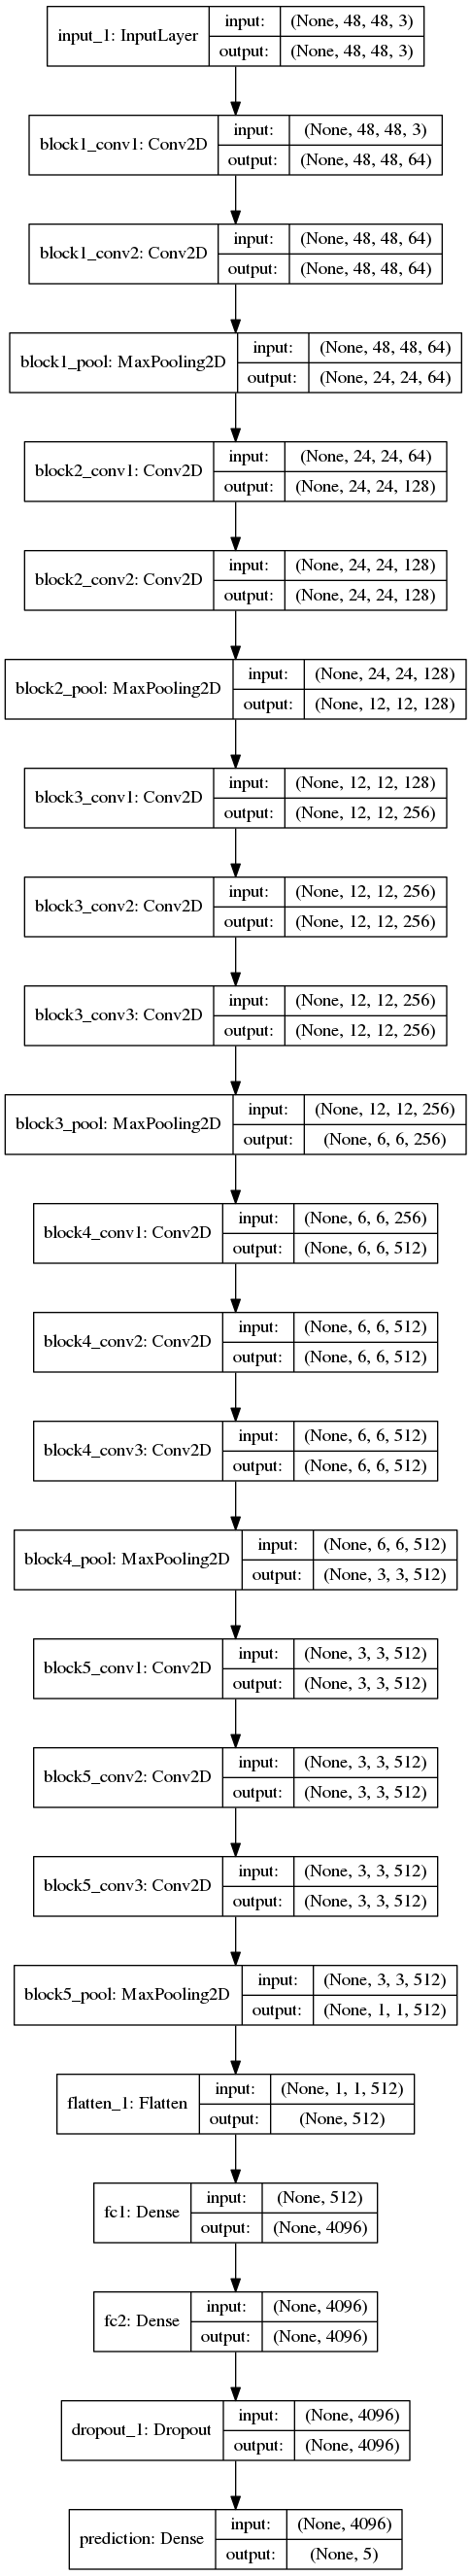

In [3]:
#导入vgg模型
model_vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (ishape, ishape, 3)) 
#将fc层失活，并且重新迁移训练
for layer in model_vgg.layers:
        layer.trainable = False
model = Flatten()(model_vgg.output) 
model = Dense(4096, activation='relu', name='fc1')(model)
model = Dense(4096, activation='relu', name='fc2')(model)
model = Dropout(0.5)(model)
model = Dense(NUM_DENSE, activation = 'softmax', name='prediction')(model) 
model_vgg_pretrain = Model(model_vgg.input, model, name = 'vgg16_pretrain')
#模型编译
sgd = SGD(lr = 0.05, decay = 1e-5) 
model_vgg_pretrain.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

#模型结构打印
plot_model(model_vgg_pretrain, to_file="model.png", show_shapes=True)
Image('model.png')

In [4]:
#下载已经打包好的数据集,本例先验{1: 'Abyssinian', 2: 'Bengal', 3: 'Birman', 4: 'Bombay', 5: 'British'}
path='littleCBIRdatasets.npz'
f = np.load(path)
X_train, y_train = f['X_train'], f['y_train']
X_test, y_test = f['X_test'], f['y_test']

In [5]:

#下载的图片进行格式转换
X_train = [cv2.resize(i, (ishape, ishape)) for i in X_train] 
X_train = [cv2.cvtColor(i, cv2.COLOR_GRAY2BGR) for i in X_train] 
# X_train = X_train[:, :, np.newaxis]
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32') 
X_train /= 255.0
# print(X_train[:1])
X_test = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in X_test] 
# X_test = X_test[:, :, np.newaxis]
X_test = np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')
X_test /= 255.0

y_train_ohe = np.array([tran_y(y_train[i]-1) for i in range(len(y_train))]) 
y_test_ohe = np.array([tran_y(y_test[i]-1) for i in range(len(y_test))])
y_train_ohe = y_train_ohe.astype('float32')
y_test_ohe = y_test_ohe.astype('float32')

In [6]:
#agumentation
# 设置生成参数
img_generator = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2
    )

#模型训练
#log = model_vgg_pretrain.fit(X_train, y_train_ohe, validation_data = (X_test, y_test_ohe), epochs = epochs, batch_size = 64)
img_generator.fit(X_train)
# fits the model_2 on batches with real-time data augmentation:
log = model_vgg_pretrain.fit_generator(img_generator.flow(X_train,y_train_ohe, batch_size=64),
                    steps_per_epoch=len(X_train), epochs=epochs, validation_data=(X_test, y_test_ohe))
score = model_vgg_pretrain.evaluate(X_test, y_test_ohe, verbose=0)
#打印显示结果
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
350/350 [==============================] - 107s 304ms/step - loss: 1.6315 - acc: 0.2020 - val_loss: 1.6341 - val_acc: 0.1533
Epoch 2/30
350/350 [==============================] - 101s 288ms/step - loss: 1.6145 - acc: 0.2036 - val_loss: 1.6287 - val_acc: 0.1800
Epoch 3/30
350/350 [==============================] - 101s 287ms/step - loss: 1.6114 - acc: 0.2062 - val_loss: 1.6265 - val_acc: 0.1933
Epoch 4/30
350/350 [==============================] - 102s 290ms/step - loss: 1.6099 - acc: 0.2099 - val_loss: 1.6322 - val_acc: 0.1467
Epoch 5/30
350/350 [==============================] - 102s 290ms/step - loss: 1.6095 - acc: 0.2072 - val_loss: 1.6278 - val_acc: 0.1333
Epoch 6/30
350/350 [==============================] - 100s 287ms/step - loss: 1.6087 - acc: 0.2084 - val_loss: 1.6275 - val_acc: 0.1467
Epoch 7/30
350/350 [==============================] - 100s 285ms/step - loss: 1.6085 - acc: 0.2135 - val_loss: 1.6337 - val_acc: 0.1533
Epoch 8/30
350/350 [============================

In [7]:
log.history

{'val_loss': [1.6340988095601399,
  1.6286872084935506,
  1.6265290021896361,
  1.6321771748860676,
  1.6277706225713093,
  1.6274629831314087,
  1.6336689186096192,
  1.6293577273686728,
  1.6339569568634034,
  1.6313546498616536,
  1.6315762344996134,
  1.6329222917556763,
  1.6319834613800048,
  1.6339771064122517,
  1.6318891525268555,
  1.6317251602808633,
  1.631111070315043,
  1.6346561670303346,
  1.6357650740941365,
  1.6322576888402303,
  1.6312395572662353,
  1.6340403699874877,
  1.6328806575139363,
  1.6331362009048462,
  1.6325323216120402,
  1.6323822482426962,
  1.6324712991714478,
  1.6335399452845256,
  1.635167670249939,
  1.6327401638031005],
 'val_acc': [0.15333333452542622,
  0.18000000099341074,
  0.19333333969116212,
  0.14666666785875956,
  0.13333333452542623,
  0.146666669100523,
  0.15333333253860473,
  0.13333333452542623,
  0.146666669100523,
  0.13333333432674407,
  0.13333333432674407,
  0.14000000208616256,
  0.15333333253860473,
  0.15333333253860473,


Text(0.5,0,'Epochs')

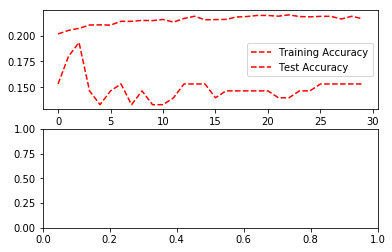

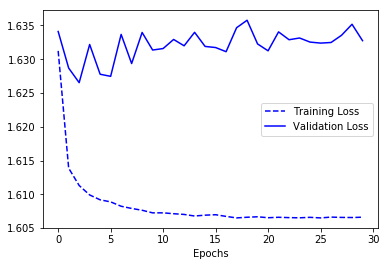

In [13]:
plt.figure('acc')  
plt.subplot(2, 1, 1)  
plt.plot(range(epochs), log.history['acc'],'r--',label='Training Accuracy') 
plt.plot(range(epochs), log.history['val_acc'],'r--',label='Test Accuracy') 
# plt.plot(range(epochs), log.history['loss'],'r--',label='Training Accuracy')   
# plt.plot(log.history['val_acc'],'r-',label='Validation Accuracy')  
plt.legend(loc='best')  
plt.xlabel('Epochs')  
# plt.axis([0, epochs, 0.9, 1])  
plt.subplot(2, 1, 2)  
plt.figure('loss')  
plt.plot(log.history['loss'],'b--',label='Training Loss')  
plt.plot(log.history['val_loss'],'b-',label='Validation Loss')  
plt.legend(loc='best')  
plt.xlabel('Epochs')  
# plt.axis([0, epochs, 0, 1])  
  

In [48]:
model.save('5type4cbirMODEL.h5')

AttributeError: 'Tensor' object has no attribute 'save'